# Classification Model Comparison (Binary vs Multi-class)

This notebook compares the best binary classifier and the best multi-class classifier on the same feature set. It reports recall/precision for the at-risk class and compares ROC-AUC using a binary projection of multi-class probabilities.

**Inputs (from 2_Outputs/):**

- best_binary_classification_model.pkl

- best_classification_model.pkl

- features_prepared.pkl

- target_binary.pkl

- target_multiclass.pkl

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
)

plt.style.use('seaborn-v0_8-darkgrid')
print('Imports ready')

Imports ready


In [2]:
# Load artifacts
best_binary_model = pickle.load(open('../2_Outputs/best_binary_classification_model.pkl', 'rb'))
best_multiclass_model = pickle.load(open('../2_Outputs/best_classification_model.pkl', 'rb'))
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
y_binary = pd.read_pickle('../2_Outputs/target_binary.pkl')
y_multiclass = pd.read_pickle('../2_Outputs/target_multiclass.pkl')

print('Artifacts loaded:')
print(f'  Features: {features.shape}')
print(f'  Binary target: {y_binary.shape}')
print(f'  Multiclass target: {y_multiclass.shape}')

Artifacts loaded:
  Features: (32593, 46)
  Binary target: (32593,)
  Multiclass target: (32593,)


In [3]:
from sklearn.metrics import accuracy_score

# Predictions
y_binary_pred = best_binary_model.predict(features)
y_binary_proba = best_binary_model.predict_proba(features)[:, 1]

y_multiclass_pred = best_multiclass_model.predict(features)
# Convert multi-class prediction to binary: 0=Safe (Distinction/Pass), 1=At Risk (Fail/Withdrawn)
y_multiclass_as_binary = (y_multiclass_pred >= 2).astype(int)
y_multiclass_proba = best_multiclass_model.predict_proba(features)
y_multiclass_proba_at_risk = y_multiclass_proba[:, 2] + y_multiclass_proba[:, 3]

# Binary comparison metrics (at-risk focus)
binary_metrics = {
    'model': 'Binary',
    'recall_at_risk': recall_score(y_binary, y_binary_pred, pos_label=1),
    'precision_at_risk': precision_score(y_binary, y_binary_pred, pos_label=1),
    'f1_at_risk': f1_score(y_binary, y_binary_pred, pos_label=1),
    'roc_auc': roc_auc_score(y_binary, y_binary_proba)
}

multiclass_metrics = {
    'model': 'Multi-class (binary projection)',
    'recall_at_risk': recall_score(y_binary, y_multiclass_as_binary, pos_label=1),
    'precision_at_risk': precision_score(y_binary, y_multiclass_as_binary, pos_label=1),
    'f1_at_risk': f1_score(y_binary, y_multiclass_as_binary, pos_label=1),
    'roc_auc': roc_auc_score(y_binary, y_multiclass_proba_at_risk)
}

df_compare = pd.DataFrame([binary_metrics, multiclass_metrics])
display(df_compare)

print('\nBinary model report:')
print(classification_report(y_binary, y_binary_pred, target_names=['Safe', 'At Risk'], zero_division=0))
print('\nMulti-class (binary projection) report:')
print(classification_report(y_binary, y_multiclass_as_binary, target_names=['Safe', 'At Risk'], zero_division=0))

# Multi-class (original labels) comparison
class_names = ['Distinction', 'Pass', 'Fail', 'Withdrawn']
multiclass_overall = {
    'model': 'Multi-class (original)',
    'accuracy': accuracy_score(y_multiclass, y_multiclass_pred),
    'macro_precision': precision_score(y_multiclass, y_multiclass_pred, average='macro', zero_division=0),
    'macro_recall': recall_score(y_multiclass, y_multiclass_pred, average='macro', zero_division=0),
    'macro_f1': f1_score(y_multiclass, y_multiclass_pred, average='macro', zero_division=0),
    'weighted_f1': f1_score(y_multiclass, y_multiclass_pred, average='weighted', zero_division=0)
}

try:
    multiclass_overall['roc_auc_ovr'] = roc_auc_score(
        y_multiclass, y_multiclass_proba, multi_class='ovr', average='macro'
    )
except Exception as e:
    multiclass_overall['roc_auc_ovr'] = np.nan
    print(f'Could not compute multiclass ROC-AUC (ovr): {e}')

df_multiclass_overall = pd.DataFrame([multiclass_overall])
display(df_multiclass_overall)

print('\nMulti-class (original labels) report:')
print(classification_report(y_multiclass, y_multiclass_pred, target_names=class_names, zero_division=0))

,model,recall_at_risk,precision_at_risk,f1_at_risk,roc_auc
0,Binary,0.951127,0.851738,0.898693,0.973531
1,Multi-class (binary projection),0.932938,0.994117,0.962557,0.992558



Binary model report:
              precision    recall  f1-score   support

        Safe       0.94      0.81      0.87     15385
     At Risk       0.85      0.95      0.90     17208

    accuracy                           0.89     32593
   macro avg       0.89      0.88      0.89     32593
weighted avg       0.89      0.89      0.89     32593


Multi-class (binary projection) report:
              precision    recall  f1-score   support

        Safe       0.93      0.99      0.96     15385
     At Risk       0.99      0.93      0.96     17208

    accuracy                           0.96     32593
   macro avg       0.96      0.96      0.96     32593
weighted avg       0.96      0.96      0.96     32593



,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_f1,roc_auc_ovr
0,Multi-class (original),0.852269,0.876195,0.763912,0.795206,0.842141,0.96799



Multi-class (original labels) report:
              precision    recall  f1-score   support

 Distinction       0.93      0.48      0.63      3024
        Pass       0.82      0.98      0.89     12361
        Fail       0.88      0.65      0.75      7052
   Withdrawn       0.88      0.94      0.91     10156

    accuracy                           0.85     32593
   macro avg       0.88      0.76      0.80     32593
weighted avg       0.86      0.85      0.84     32593



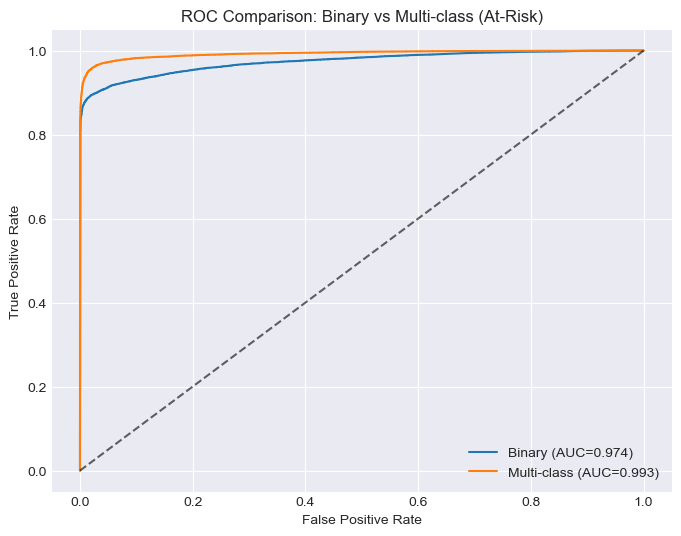

In [4]:
# ROC curves
fpr_bin, tpr_bin, _ = roc_curve(y_binary, y_binary_proba)
fpr_mc, tpr_mc, _ = roc_curve(y_binary, y_multiclass_proba_at_risk)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bin, tpr_bin, label='Binary (AUC={:.3f})'.format(binary_metrics['roc_auc']))
plt.plot(fpr_mc, tpr_mc, label='Multi-class (AUC={:.3f})'.format(multiclass_metrics['roc_auc']))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison: Binary vs Multi-class (At-Risk)')
plt.legend()
plt.show()

## Critical Comparison and Interpretation

**Binary (at-risk) model vs. multi-class (binary projection):**
- The binary model is optimized to separate *Safe* vs *At Risk* students, so it typically yields higher recall for the at-risk class. This is useful when the priority is early intervention and missing at-risk students is costly.
- The multi-class model, when collapsed into binary outcomes, often trades some at-risk recall for a more nuanced view of outcomes. This indicates a broader but less focused decision boundary for risk detection.

**Multi-class (original labels):**
- Macro metrics (precision/recall/F1) treat each class equally, so lower macro scores indicate underperformance on minority classes like *Withdrawn*.
- Weighted metrics will look stronger if the dataset is imbalanced; interpret them alongside macro scores to avoid overstating performance.
- Multiclass ROC-AUC (one-vs-rest) summarizes ranking quality across classes, but it can mask poor discrimination for smaller classes.

**Implications:**
- If the operational goal is *risk triage*, the binary model is more actionable because it maximizes recall for at-risk students.
- If the goal is *outcome forecasting* (e.g., distinguishing *Fail* from *Withdrawn*), the multi-class model is more informative, but it requires stronger downstream policies to act on each class.

**Recommendation:**
- Use the binary model for early-warning interventions and the multi-class model for later-stage diagnostic planning, or run both in parallel for complementary insights.